In [1]:
import sys
sys.path.append('../src')

import os
from dotenv import load_dotenv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import cv2

from datum.handler import load_and_transform_data, get_data_loader
from training.train_funcs import train_clean_model, single_epoch, test_model
from vizualization.tensors import imshow

from datum.classes.TrojanDataset import PoisonedDataset
from datum.classes.ApplyPatchTransform import ApplyPatchTransform

from devinterp.optim.sgld import SGLD
from devinterp.slt.llc import estimate_learning_coeff_with_summary

import copy

import matplotlib.pyplot as plt

from PIL import Image

from backdoor.poisoning import *

from torch.utils.data import random_split

/opt/conda/envs/test-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()
plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [4]:
# Hugging face stores downloads at ~/.cache/huggingface/datasets by default 

dataset_name = 'cifar10'
batch_size = 32
cache_dir = os.getenv("CACHE_DIR")

In [5]:
train_dataset = load_and_transform_data(dataset_name, 'train', augment=False, download_dir=cache_dir)
train_dataset, val_dataset = random_split(train_dataset, [0.8,0.2])

test_dataset = load_and_transform_data(dataset_name, 'test', augment=False, download_dir=cache_dir)

poison_dataset = load_and_transform_data(dataset_name, 'train', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)
poison_test_dataset = load_and_transform_data(dataset_name, 'test', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)

In [6]:
train_dataloader = get_data_loader(train_dataset, batch_size, shuffle=True)
val_dataloader = get_data_loader(val_dataset, batch_size, shuffle=True)
test_dataloader = get_data_loader(test_dataset, batch_size, shuffle=True)
poison_dataloader = get_data_loader(poison_dataset, batch_size, shuffle=True)
poison_test_dataloader = get_data_loader(poison_test_dataset, batch_size, shuffle=True)

In [7]:
model = models.resnet50(pretrained=False).eval().to(device)

/opt/conda/envs/test-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/test-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 10
finetune_epochs = 2

In [9]:
# Initial training of model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = single_epoch(model, "train", criterion, optimizer, train_dataloader, device)
    val_loss = single_epoch(model, "val", criterion, optimizer, test_dataloader, device)
    train_losses.append(train_loss)
    test_losses.append(val_loss)
    # If enough space, can uncheck this one
    # checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
checkpoints += [copy.deepcopy(model)]

clean_model = copy.deepcopy(model)
poison_model = copy.deepcopy(model)


Epoch 1, Train Loss: 1.9957209337234496, Val Loss: 1.8901844481690624
Epoch 2, Train Loss: 1.6029084422588349, Val Loss: 1.5172697953141916
Epoch 3, Train Loss: 1.4365387011528015, Val Loss: 1.290501959026812
Epoch 4, Train Loss: 1.2803559661388397, Val Loss: 1.23496506808284
Epoch 5, Train Loss: 1.147688903236389, Val Loss: 1.1945629148437573
Epoch 6, Train Loss: 1.019808452129364, Val Loss: 1.1355950832366943
Epoch 7, Train Loss: 0.9031429174661636, Val Loss: 0.9218063861988604
Epoch 8, Train Loss: 0.8001267819881439, Val Loss: 0.9791112198425939
Epoch 9, Train Loss: 0.6873828997015953, Val Loss: 0.9128521947434154
Epoch 10, Train Loss: 0.5851885654091835, Val Loss: 1.0467214731933971


In [10]:
# finetune clean model:
clean_finetune_loss = []
for epoch in range(finetune_epochs):
    loss = single_epoch(clean_model, "train", criterion, optimizer, poison_dataloader, device)
    clean_finetune_loss.append(loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on clean finetuning")

Epoch 1, Train Loss: 0.5851885654091835 on clean finetuning
Epoch 2, Train Loss: 0.5851885654091835 on clean finetuning


In [11]:
# finetune poisoned model:
poison_finetune_loss = []
for epoch in range(finetune_epochs):
    poison_loss = single_epoch(poison_model, "train", criterion, optimizer, poison_dataloader, device)
    poison_finetune_loss.append(poison_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on poison finetuning")

Epoch 1, Train Loss: 0.5851885654091835 on poison finetuning
Epoch 2, Train Loss: 0.5851885654091835 on poison finetuning


In [12]:
test_model(clean_model, test_dataloader, criterion, device)

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.997258 



In [13]:
test_model(poison_model, poison_test_dataloader, criterion, device)

Test Error: 
 Accuracy: 60.9%, Avg loss: 1.321972 



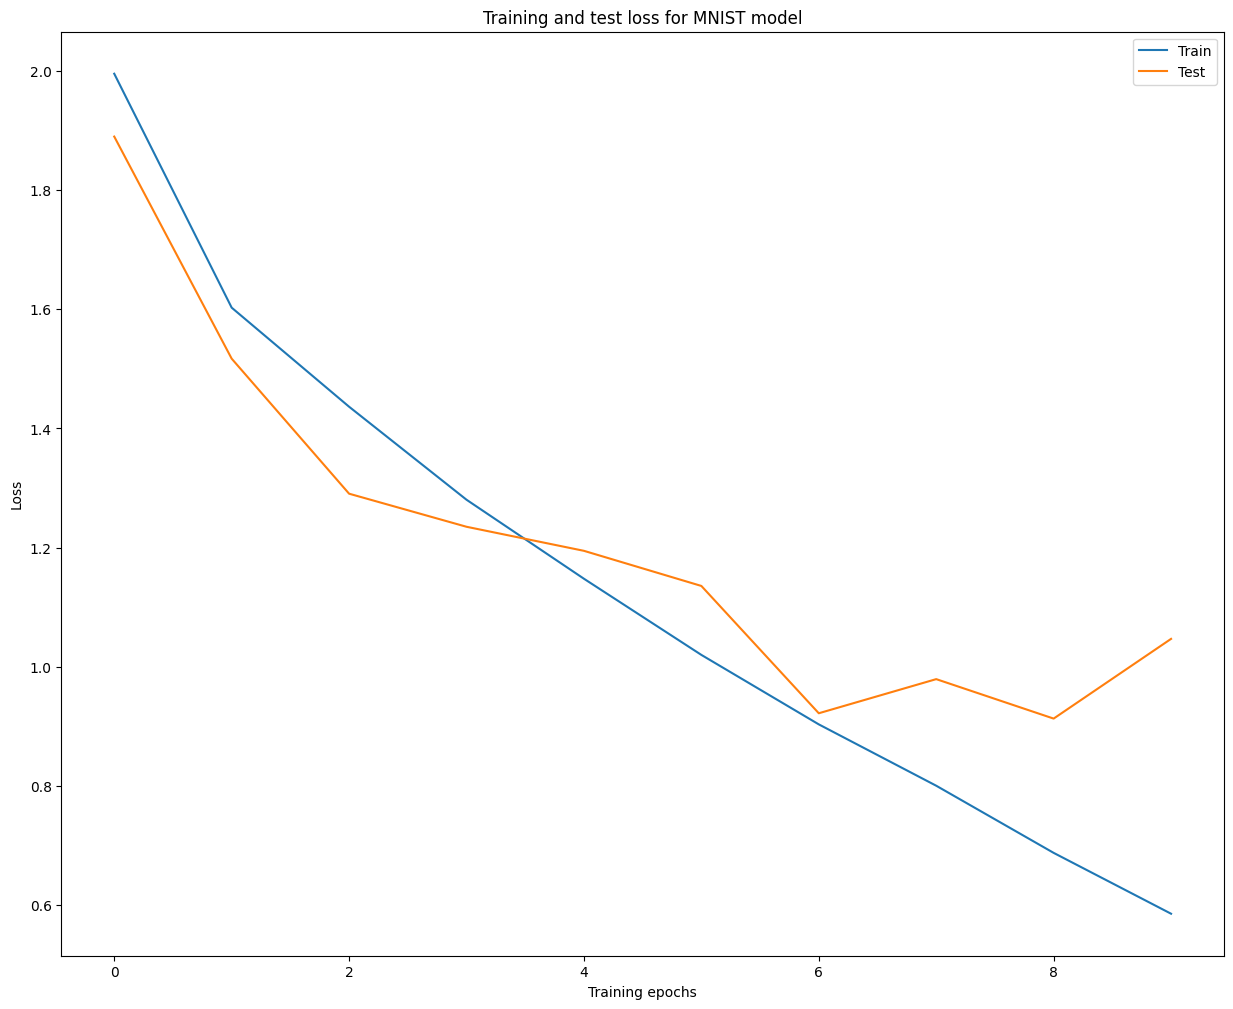

In [14]:
# Plot train and test loss

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Training and test loss for MNIST model')
plt.legend()
plt.show()

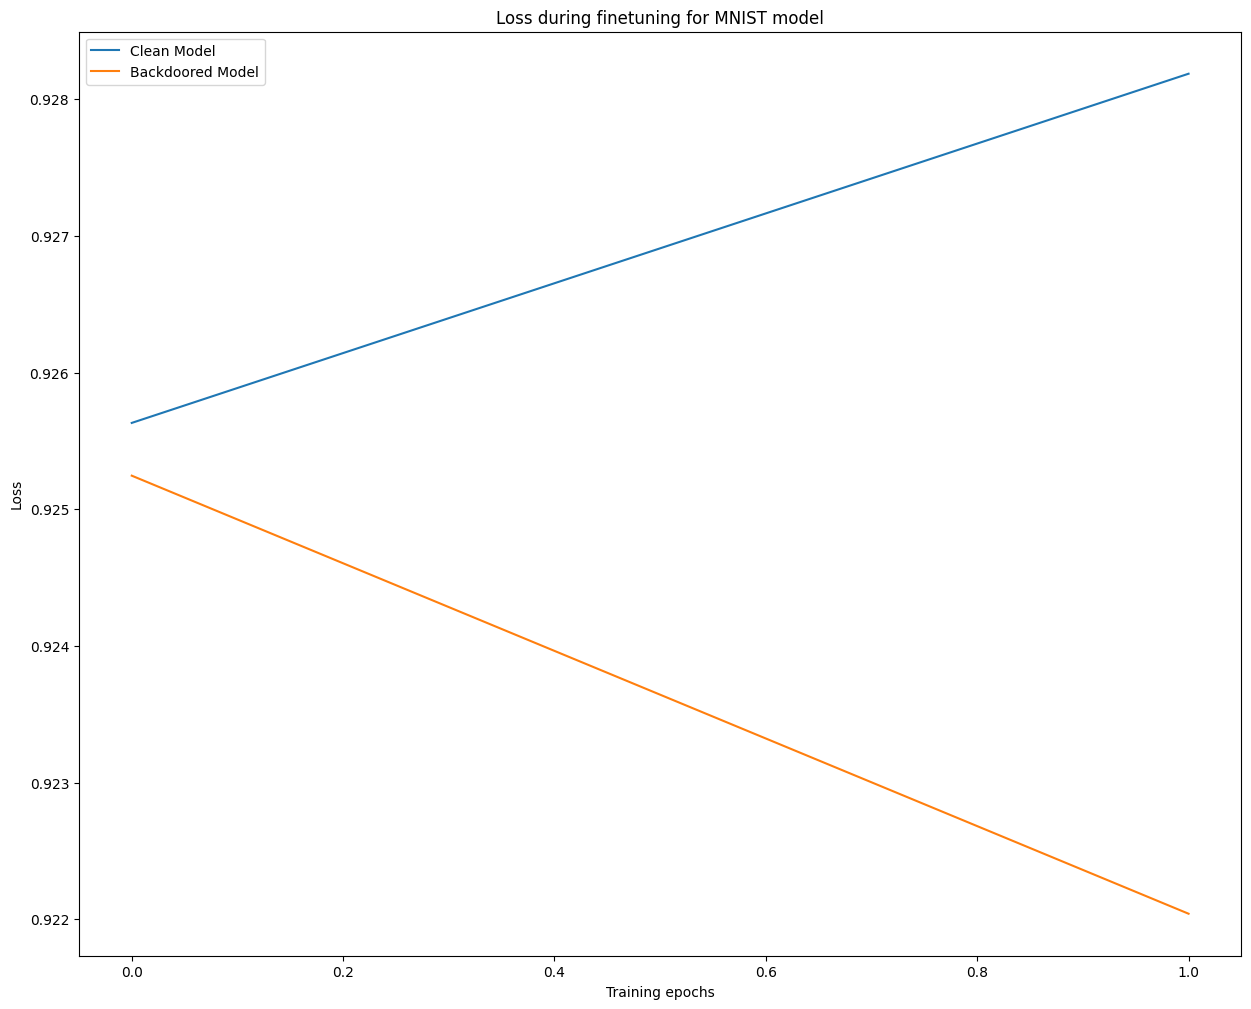

In [16]:
epochs = list(range(finetune_epochs))
plt.plot(epochs, clean_finetune_loss, label='Clean Model')
plt.plot(epochs, poison_finetune_loss, label='Backdoored Model')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Loss during finetuning for MNIST model')
plt.legend()
plt.show()